# EDA: Events, Funnel and Filtering Strategy

Цель:
- изучить временную структуру событий,
- понять воронку view → addtocart → transaction,
- сформировать стратегию фильтрации пользователей и товаров
  для построения рекомендательной системы.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

DATA_PATH = "../data/raw/events.csv"
events = pd.read_csv(DATA_PATH)

events["timestamp"] = pd.to_datetime(events["timestamp"], unit="ms")
events["date"] = events["timestamp"].dt.date
events["hour"] = events["timestamp"].dt.hour

events.head()


,timestamp,visitorid,event,itemid,transactionid,date,hour
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2015-06-02,5
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2015-06-02,5
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2015-06-02,5
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2015-06-02,5
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2015-06-02,5


In [2]:
events_per_day = events.groupby("date").size()

events_per_day.describe()


count      139.000000
mean     19828.064748
std       4170.654332
min       1528.000000
25%      16831.500000
50%      20621.000000
75%      22461.000000
max      32703.000000
dtype: float64

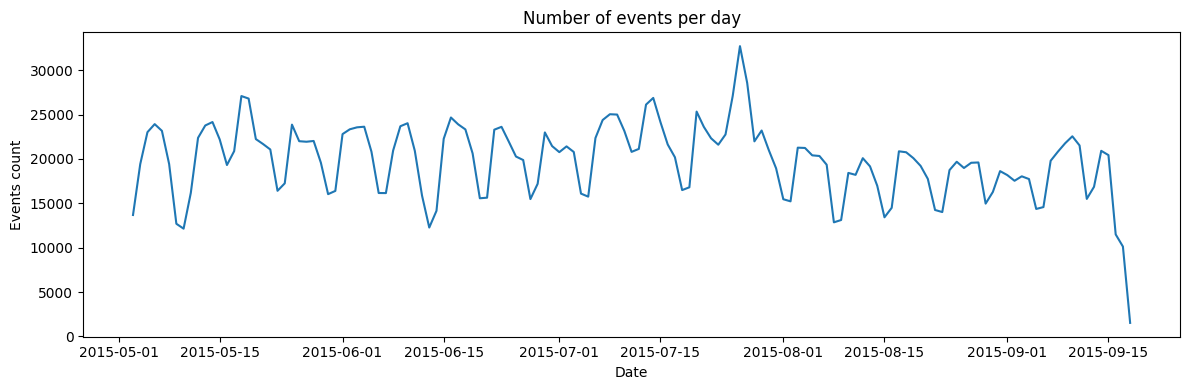

In [3]:
plt.figure(figsize=(12, 4))
events_per_day.plot()
plt.title("Number of events per day")
plt.xlabel("Date")
plt.ylabel("Events count")
plt.tight_layout()
plt.show()


## Временная динамика событий

- Данные охватывают период с **2015-05-03** по **2015-09-18** (~4.5 месяца).
- Среднее число событий в день — около **19–20 тысяч**, что говорит о стабильном потоке трафика.
- Наблюдаются регулярные колебания активности, вероятно связанные с дневными/недельными паттернами.
- В конце датасета заметен резкий спад активности — это указывает на **обрезанный период сбора данных**, а не реальное падение интереса пользователей.

**Вывод:**  
Данные подходят для временного сплита, однако последние дни датасета
следует использовать с осторожностью или исключить из тестирования.


In [4]:
events_per_day_type = (
    events
    .groupby(["date", "event"])
    .size()
    .unstack(fill_value=0)
)

events_per_day_type.tail()


event,addtocart,transaction,view
date,,,
2015-09-14,475,154,20284
2015-09-15,595,158,19674
2015-09-16,336,137,11022
2015-09-17,253,45,9830
2015-09-18,34,15,1479


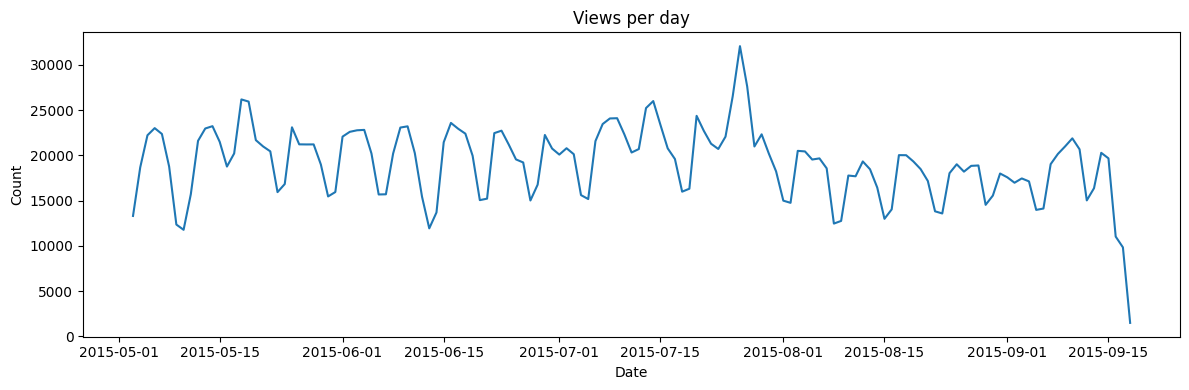

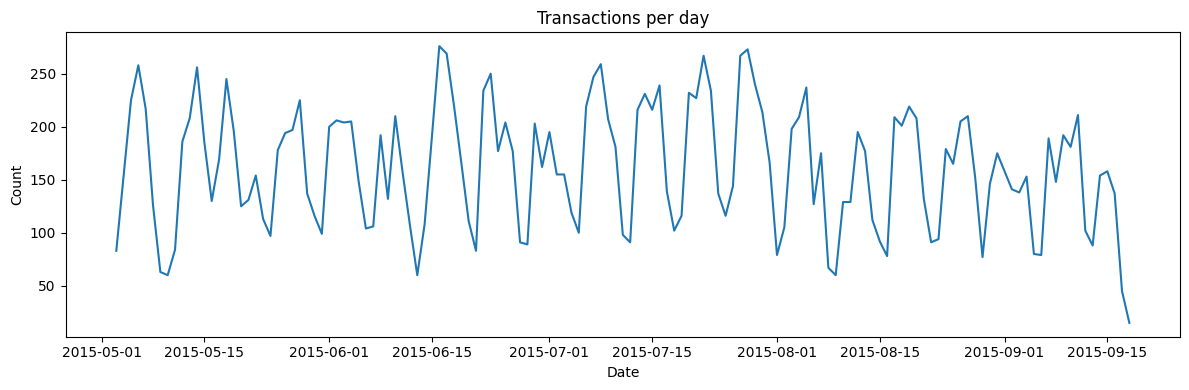

In [5]:
plt.figure(figsize=(12, 4))
events_per_day_type["view"].plot()
plt.title("Views per day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
events_per_day_type["transaction"].plot()
plt.title("Transactions per day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Динамика событий по типам

- Просмотры (`view`) доминируют на всём временном интервале и формируют основной объём данных.
- Покупки (`transaction`) значительно более редки, но демонстрируют схожую динамику с просмотрами.
- Это указывает на логичную связь между интересом пользователей и фактическими покупками.

**Вывод:**  
Покупки являются редким, но информативным сигналом, который можно использовать
как целевое событие для оценки качества рекомендаций.


In [6]:
events["event"].value_counts(normalize=True)


event
view           0.966696
addtocart      0.025156
transaction    0.008148
Name: proportion, dtype: float64

In [7]:
users_view = set(events.loc[events["event"] == "view", "visitorid"])
users_cart = set(events.loc[events["event"] == "addtocart", "visitorid"])
users_trans = set(events.loc[events["event"] == "transaction", "visitorid"])

len_users_view = len(users_view)
len_users_cart = len(users_cart)
len_users_trans = len(users_trans)

len_users_view, len_users_cart, len_users_trans


(1404179, 37722, 11719)

In [8]:
cart_from_view = len(users_cart) / len(users_view)
trans_from_view = len(users_trans) / len(users_view)
trans_from_cart = len(users_trans & users_cart) / len(users_cart)

cart_from_view, trans_from_view, trans_from_cart


(0.026864096386571796, 0.008345802066545647, 0.28036689465033665)

In [9]:
user_activity = events.groupby("visitorid").size()
user_activity.describe()
user_activity.quantile([0.5, 0.9, 0.99])


0.50     1.0
0.90     3.0
0.99    13.0
dtype: float64

## Воронка пользовательских действий

Количество пользователей:
- Совершили хотя бы один просмотр: **~1.40 млн**
- Добавили товар в корзину: **~37.7 тыс**
- Совершили покупку: **~11.7 тыс**

Конверсии:
- view → addtocart: **~2.7%**
- view → transaction: **~0.83%**
- addtocart → transaction: **~28%**

**Интерпретация:**
- Большинство пользователей ограничиваются просмотром товаров.
- Добавление в корзину — сильный индикатор намерения.
- Почти каждый третий пользователь, добавивший товар в корзину, совершает покупку.

**Вывод:**  
Для рекомендательной системы особенно ценны события `addtocart` и `transaction`,
однако из-за их редкости основное обучение будет строиться на implicit feedback
(просмотрах) с приоритетом оценки по покупкам.


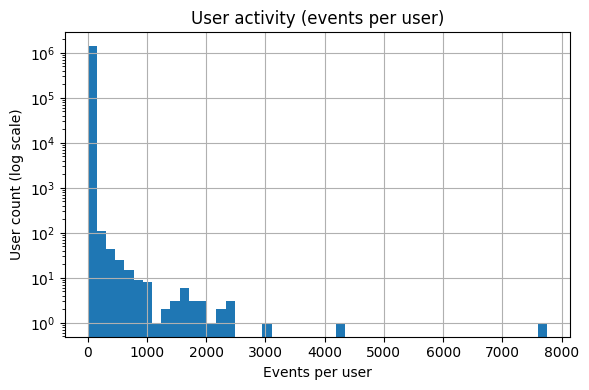

In [10]:
plt.figure(figsize=(6, 4))
user_activity.hist(bins=50)
plt.yscale("log")
plt.title("User activity (events per user)")
plt.xlabel("Events per user")
plt.ylabel("User count (log scale)")
plt.tight_layout()
plt.show()


In [11]:
for thr in [1, 2, 3, 5, 10]:
    users_kept = (user_activity >= thr).sum()
    events_kept = events[events["visitorid"].isin(user_activity[user_activity >= thr].index)].shape[0]
    print(f"thr={thr}: users kept={users_kept}, events kept={events_kept}")


thr=1: users kept=1407580, events kept=2756101
thr=2: users kept=406020, events kept=1754541
thr=3: users kept=200028, events kept=1342557
thr=5: users kept=81620, events kept=948537
thr=10: users kept=23241, events kept=583304


In [12]:
item_popularity = events.groupby("itemid").size()
item_popularity.describe()
item_popularity.quantile([0.5, 0.9, 0.99])


0.50      3.0
0.90     25.0
0.99    143.0
dtype: float64

## Активность пользователей

- 50% пользователей имеют **только 1 событие**.
- 90% пользователей имеют **не более 3 событий**.
- Лишь небольшой процент пользователей демонстрирует высокую активность
  (long-tail распределение).

Эффект фильтрации:
- При `min_user_events = 3`:
  - остаётся ~200k пользователей,
  - сохраняется ~1.34 млн событий.
- При `min_user_events = 5`:
  - остаётся ~82k пользователей,
  - сохраняется ~0.95 млн событий.

**Вывод:**  
Для обучения моделей рекомендаций целесообразно исключить одноразовых пользователей.
Оптимальным компромиссом между объёмом данных и качеством сигналов
является порог `min_user_events = 3`.


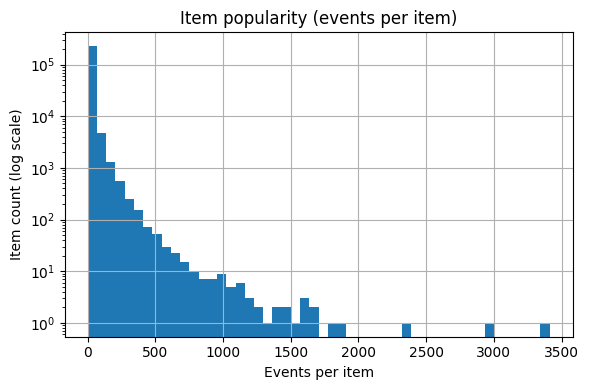

In [13]:
plt.figure(figsize=(6, 4))
item_popularity.hist(bins=50)
plt.yscale("log")
plt.title("Item popularity (events per item)")
plt.xlabel("Events per item")
plt.ylabel("Item count (log scale)")
plt.tight_layout()
plt.show()


In [14]:
for thr in [1, 2, 3, 5, 10]:
    items_kept = (item_popularity >= thr).sum()
    events_kept = events[events["itemid"].isin(item_popularity[item_popularity >= thr].index)].shape[0]
    print(f"thr={thr}: items kept={items_kept}, events kept={events_kept}")


thr=1: items kept=235061, events kept=2756101
thr=2: items kept=161452, events kept=2682492
thr=3: items kept=126623, events kept=2612834
thr=5: items kept=90948, events kept=2491203
thr=10: items kept=55128, events kept=2255256


In [15]:
events["timestamp"].min(), events["timestamp"].max()


(Timestamp('2015-05-03 03:00:04.384000'),
 Timestamp('2015-09-18 02:59:47.788000'))

## Популярность товаров

- Медиана числа событий на товар — **3**.
- 90% товаров имеют **≤25 событий**.
- Распределение имеет выраженный long-tail:
  большинство товаров крайне редко взаимодействуют с пользователями.

Эффект фильтрации:
- При `min_item_events = 5`:
  - остаётся ~91k товаров,
  - сохраняется ~2.49 млн событий.
- При `min_item_events = 10`:
  - остаётся ~55k товаров,
  - сохраняется ~2.25 млн событий.

**Вывод:**  
Удаление ультра-редких товаров снижает разреженность user–item матрицы
и повышает стабильность моделей.
Рекомендуемый порог: `min_item_events = 5`.


In [16]:
events_sorted = events.sort_values("timestamp")
events_sorted["cum_events"] = np.arange(len(events_sorted)) + 1
events_sorted["cum_events_rel"] = events_sorted["cum_events"] / len(events_sorted)


In [17]:
cut_80 = events_sorted.loc[
    (events_sorted["cum_events_rel"] >= 0.8), "timestamp"
].iloc[0]
cut_80


Timestamp('2015-08-18 04:23:31.966000')

## Временной сплит данных

- 80% всех событий по времени соответствуют дате **2015-08-18**.
- Это позволяет реализовать реалистичный временной сплит:

Предложенная схема:
- **Train**: события до 2015-08-18
- **Validation**: следующий временной интервал
- **Test**: самый свежий период данных

**Вывод:**  
Временной сплит предотвращает data leakage и корректно имитирует
реальный сценарий работы рекомендательной системы.


Идея сплита:

- train: ранний период (например, первые 70–80% событий по времени);
- validation: следующий временной отрезок;
- test: самый свежий отрезок.

В дальнейшем логика будет реализована в модуле `src/data/preprocessing.py`.


## Итоговые выводы EDA

- Датасет имеет стабильную временную структуру и подходит для временного разбиения.
- Покупки — редкий, но ключевой сигнал для оценки рекомендаций.
- Распределения пользователей и товаров имеют выраженный long-tail.
- Для дальнейшей работы выбраны фильтры:
  - `min_user_events = 3`
  - `min_item_events = 5`
- Для offline-оценки будет использоваться временной split train/validation/test.

Следующий шаг — реализация фильтрации и временного сплита в коде
и построение baseline-модели рекомендаций.
